In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import glob

## Analyze results using our Exp 3 human data

In [5]:
# Grab only sorted uncolored filenames
fnames = sorted(glob.glob('../../humans/data_ours/*uncolored_sorted*.csv'))
print('There are', len(fnames), 'participants.')

def process(df):
    relevant_cols = [
        'Participant #', 
        'current_problem_num', 
        'accuracy', 
        'trials.thisTrialN',
        'expName'
    ]
    df = df[relevant_cols]

    # Rename for consistency
    df = df.rename(columns = {'Participant #': 'participant', 'current_problem_num': 'problem', 'trials.thisTrialN': 'raw_trials'})

    # No nulls
    df = df[df['problem'].notnull()]

    # Count all trials
    df = df.groupby(['problem','participant']).raw_trials.count().to_frame().reset_index()

    # Trial counts are not trials to criterion yet (need to subtract 7, unless fail)
    df['trials_to_criterion'] = [34 if raw_trial == 34 else raw_trial - 7 for raw_trial in df.raw_trials]

    df = df.drop(columns = ['raw_trials'])

    # New column source
    df['source'] = 'Human Data'

    return df

# Calculate dependent variable for each participant 
human_data = pd.DataFrame()
for fname in fnames:
    df = pd.read_csv(fname)
    human_data = pd.concat([human_data, process(df)], ignore_index=True)
display(human_data)

There are 34 participants.


,problem,participant,trials_to_criterion,source
0,1.0,100,0,Human Data
1,2.0,100,10,Human Data
2,3.0,100,34,Human Data
3,4.0,100,13,Human Data
4,5.0,100,24,Human Data
...,...,...,...,...
777,19.0,96,4,Human Data
778,20.0,96,12,Human Data
779,21.0,96,7,Human Data
780,22.0,96,0,Human Data


In [6]:
# gpt-4o results
all_results = pd.read_csv('results/23_limited_results.csv')
print(all_results.columns)

Index(['Unnamed: 0', 'trial', 'file_path', 'shortened_file_path', 'problem',
       'category', 'exemplar', 'num_calls_to_API', 'raw_response_to_trial',
       'selected_category', 'accuracy', 'correct_in_row', 'feedback',
       'raw_response_to_feedback', 'feedback_response',
       'raw_response_to_next_problem', 'next_problem_response', 'temperature'],
      dtype='object')


In [11]:
final_results = all_results.groupby(['problem']).trial.count().to_frame().reset_index()
final_results = final_results.rename(columns = {'trial': 'trials_to_criterion'})
final_results['source'] = 'gpt-4-vision-preview / High Image Detail'

# Concat both files
final_results = pd.concat([final_results, human_data])
final_results = final_results.sort_values('source')

# Problem column is integer
final_results['problem'] = final_results['problem'].astype(int)

display(final_results)

,problem,trials_to_criterion,source,participant
379,12,34,Human Data,32.0
507,2,1,Human Data,52.0
508,3,11,Human Data,52.0
509,4,0,Human Data,52.0
510,5,5,Human Data,52.0
...,...,...,...,...
19,20,34,gpt-4-vision-preview / High Image Detail,NaN
20,21,34,gpt-4-vision-preview / High Image Detail,NaN
22,23,34,gpt-4-vision-preview / High Image Detail,NaN
11,12,34,gpt-4-vision-preview / High Image Detail,NaN


In [12]:
# Save results
final_results.to_csv('gpt-4-vision-preview_limited_highdetail.csv')

### Plot ordered by human data

<Figure size 640x480 with 0 Axes>

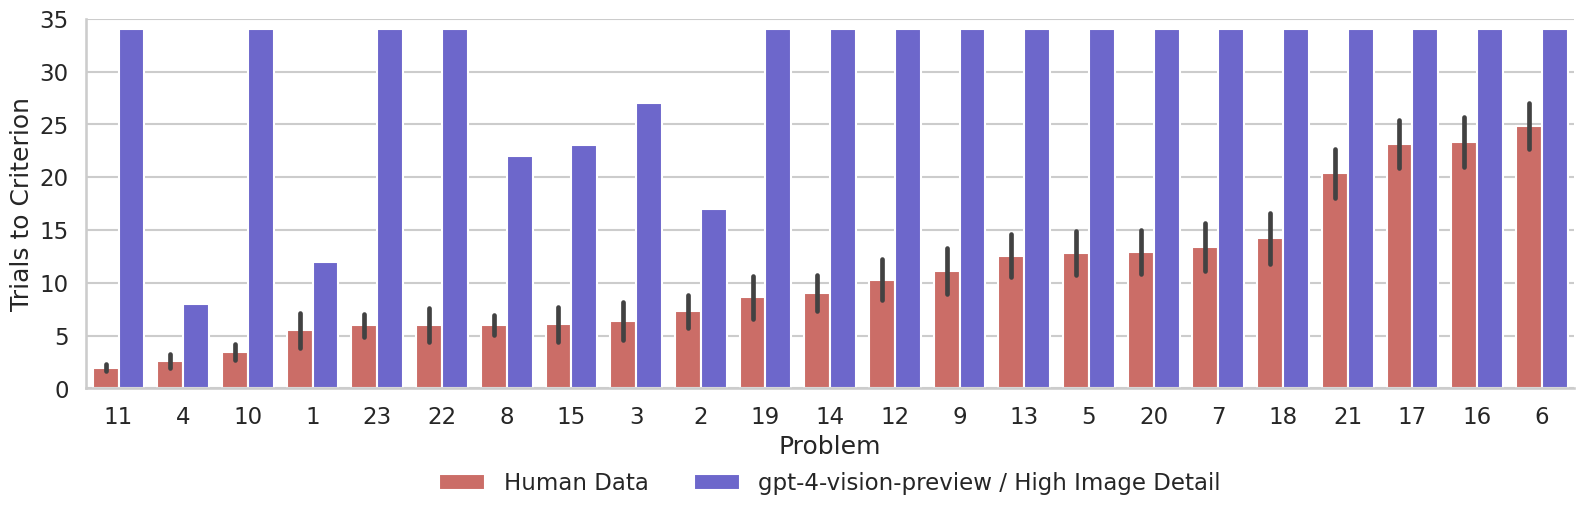

In [13]:
# Order of problem difficulty based on problem means calculated WITH participant fails
my_problem_means = human_data.groupby(['problem']).trials_to_criterion.mean().to_frame().reset_index()
order_problem_means_with_fails = my_problem_means.sort_values('trials_to_criterion').problem.astype(int).to_list()

#
sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette('hls', 2)
plt.tight_layout()

# Plot
plt.figure(figsize = (6.4*3, 4.8))
sns.barplot(
    data = final_results,
    x = 'problem',
    y = 'trials_to_criterion',
    hue = 'source',
    errorbar = 'se',
    order = order_problem_means_with_fails,
    palette = [
        sns.hls_palette()[0],
        sns.hls_palette()[4]
    ]
).set(
    xlabel = 'Problem',
    ylabel = 'Trials to Criterion',
    ylim = (0,35),
    title = ''
)
plt.legend(bbox_to_anchor=(0.5, -0.17), loc='upper center', ncol=4).get_frame().set_linewidth(0.0)
sns.despine()

### Plot of same-different vs. spatial relations

,problem,raw_trials,trials_to_criterion,source,participant,relation_color
3,4,8.0,1,gpt-4-vision-preview / High Image Detail,NaN,"(0.33999999999999997, 0.8287999999999999, 0.86)"
0,1,12.0,5,gpt-4-vision-preview / High Image Detail,NaN,"(0.86, 0.3712, 0.33999999999999997)"
1,2,17.0,10,gpt-4-vision-preview / High Image Detail,NaN,"(0.33999999999999997, 0.8287999999999999, 0.86)"
7,8,22.0,15,gpt-4-vision-preview / High Image Detail,NaN,"(0.86, 0.33999999999999997, 0.8287999999999999)"
14,15,23.0,16,gpt-4-vision-preview / High Image Detail,NaN,"(0.86, 0.3712, 0.33999999999999997)"
2,3,27.0,20,gpt-4-vision-preview / High Image Detail,NaN,"(0.33999999999999997, 0.8287999999999999, 0.86)"
22,23,34.0,34,gpt-4-vision-preview / High Image Detail,NaN,"(0.33999999999999997, 0.8287999999999999, 0.86)"
17,18,34.0,34,gpt-4-vision-preview / High Image Detail,NaN,"(0.33999999999999997, 0.8287999999999999, 0.86)"
9,10,34.0,34,gpt-4-vision-preview / High Image Detail,NaN,"(0.33999999999999997, 0.8287999999999999, 0.86)"
11,12,34.0,34,gpt-4-vision-preview / High Image Detail,NaN,"(0.33999999999999997, 0.8287999999999999, 0.86)"


/tmp/ipykernel_1186907/3969992857.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


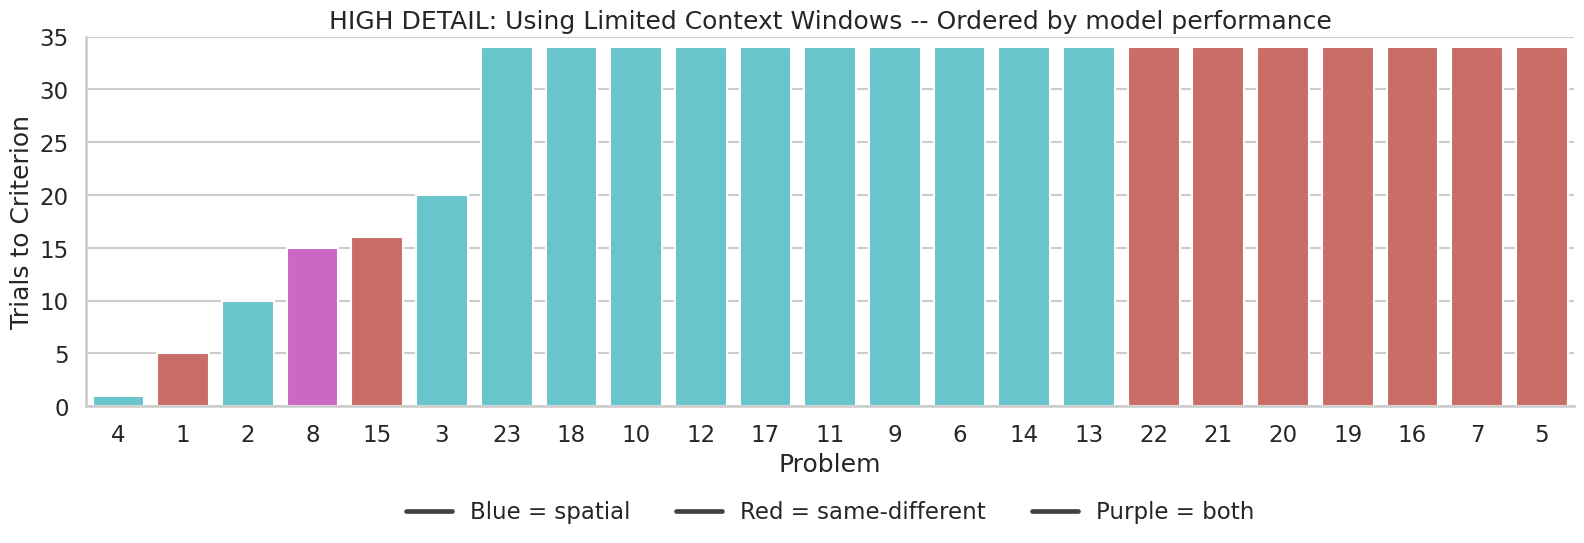

In [16]:
# Just gpt results
results_gpt = final_results[final_results.source == 'gpt-4-vision-preview / High Image Detail']

# SORT VALUES by trials to criterion
results_gpt = results_gpt.sort_values('trials_to_criterion')

# Order of problem difficulty based on problem means calculated WITH participant fails
order_gpt = results_gpt.problem.to_list()

# Lists of x-ticks for different coloring
same_different = [20,7,21,19,1,22,5,15,16,]  
spatial = [6,17,9,13,23,14,4,12,10,18,3,11,2]
both = [8]

# Create a color list based on membership in the lists above
def assign_color(problem):
    if problem in same_different:
        return (0.86, 0.3712, 0.33999999999999997)  # seaborn hls red
    elif problem in spatial:
        return (0.33999999999999997, 0.8287999999999999, 0.86)  # seaborn hls blue
    elif problem in both:
        return (0.86, 0.33999999999999997, 0.8287999999999999)  # seaborn hls light purple
results_gpt['relation_color'] = [assign_color(problem) for problem in results_gpt['problem']]

# Sort values again 
results_gpt = results_gpt.sort_values(['trials_to_criterion','relation_color'])

display(results_gpt)

# Plot
plt.figure(figsize = (6.4*3, 4.8))
sns.set_context('talk')
sns.set_style("whitegrid")
plt.tight_layout()
sns.barplot(
    data = results_gpt,
    x = 'problem',
    y = 'trials_to_criterion',
    order = results_gpt['problem'],
    palette = results_gpt['relation_color'].to_list()
).set(
    xlabel = 'Problem',
    ylabel = 'Trials to Criterion',
    ylim = (0,35),
    title = 'HIGH DETAIL: Using Limited Context Windows -- Ordered by model performance'
)
plt.legend(labels=['Blue = spatial', 'Red = same-different', 'Purple = both'], bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=4).get_frame().set_linewidth(0.0)
sns.despine()